# 🎯💻 Financial Sentiment Analysis Using Spacy and Word2Vec

# 1. 📌 Installing and Importing Libraries

In [1]:
# Installing Gensim Library
!pip install --upgrade gensim -q

In [2]:
# Basic Libraires
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Text Preprocessing Library
import spacy
import re

# Word2Vec Model Library
import gensim
from gensim.models import word2vec
from gensim.models.word2vec import Word2Vec
import gensim.downloader as api

# Models Libraries
import pickle
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import SGDClassifier
from catboost import CatBoostClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV

# Evaluation Metric Libraries
from sklearn.metrics import confusion_matrix, accuracy_score

/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: libtensorflow_io.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so: undefined symbol: _ZTVN10tenso

# 2. 💉 Importing Dataset

In [3]:
df = pd.read_csv('/kaggle/input/financial-sentiment-analysis/data.csv')
df.head()

,Sentence,Sentiment
0,The GeoSolutions technology will leverage Bene...,positive
1,"$ESI on lows, down $1.50 to $2.50 BK a real po...",negative
2,"For the last quarter of 2010 , Componenta 's n...",positive
3,According to the Finnish-Russian Chamber of Co...,neutral
4,The Swedish buyout firm has sold its remaining...,neutral


In [4]:
df.describe()

,Sentence,Sentiment
count,5842,5842
unique,5322,3
top,Managing Director 's comments : `` Net sales f...,neutral
freq,2,3130


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5842 entries, 0 to 5841
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Sentence   5842 non-null   object
 1   Sentiment  5842 non-null   object
dtypes: object(2)
memory usage: 91.4+ KB


In [6]:
df.shape

(5842, 2)

So, Our dataset has 5842 records with no null valued record. The output classes are - {'Positive', 'Negative', 'Neutral'}

# 3. 🔭 Exploratory Data Analysis

<Axes: xlabel='Sentiment', ylabel='count'>

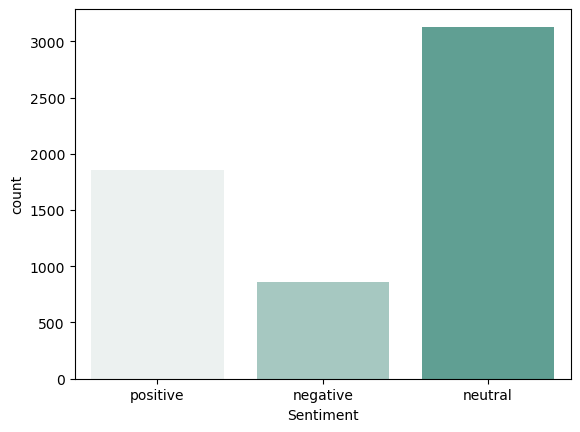

In [7]:
sns.countplot(data=df, x='Sentiment', palette='light:#5A9')

In [8]:
df['Sentiment'].value_counts()

neutral     3130
positive    1852
negative     860
Name: Sentiment, dtype: int64

So we have total of 5842 records of which - 
<br>Neutral records are 3130 - <b>53.57% </b>
<br>Positive records are 1852 - <b>31.7% </b>
<br>negative records are 860 - <b>14.72% </b>

# 4. 🛠️ Feature Engineering (Text Preprocessing)

In [9]:
nlp = spacy.load('en_core_web_sm')
stop_words = nlp.Defaults.stop_words

In [10]:
import gensim.downloader as api
print(list(gensim.downloader.info()['models'].keys()))

['fasttext-wiki-news-subwords-300', 'conceptnet-numberbatch-17-06-300', 'word2vec-ruscorpora-300', 'word2vec-google-news-300', 'glove-wiki-gigaword-50', 'glove-wiki-gigaword-100', 'glove-wiki-gigaword-200', 'glove-wiki-gigaword-300', 'glove-twitter-25', 'glove-twitter-50', 'glove-twitter-100', 'glove-twitter-200', '__testing_word2vec-matrix-synopsis']


These are all the Word2Vec pretrained models available in gensim library. We will use <b>'word2vec-google-news-300'</b> model to convert our words to vectors. The dimension of each vectors will be 300x1. 

In [11]:
wv = api.load('word2vec-google-news-300')

[==================================================] 100.0% 1662.8/1662.8MB downloaded


In [12]:
print(type(wv))

<class 'gensim.models.keyedvectors.KeyedVectors'>


Now we are going to define a function called 'sent_vec()'. The purpose of this function is to convert all the words in a sentance into vectors and take average of all these vectors so that the dimension of all the sentences is 300x1.

In [13]:
def sent_vec(sent):
    vector_size = wv.vector_size
    wv_res = np.zeros(vector_size)
    count = 1
    for word in sent:
        if word in wv:
            count+=1
            wv_res = wv[word]
    wv_res = wv_res/count # taking the average
    return wv_res

In [14]:
def preprocess(sentence):
    # Removing the numbers, special characters, etc from the sentence and replacing them with " "
    sentence = re.sub('[^a-zA-Z]',' ',sentence)
    # Converting sentence into a spacy doc - which is a sequence of tokens
    doc = nlp(sentence)
    # Lemmatization and lower casing the words
    tokens = [word.lemma_.lower().strip() for word in doc]
    # Removing stop words and punctuations
    tokens = [word for word in tokens if word not in stop_words]
    return tokens

In [15]:
# Step-1 : Converting Sentences into tokens
df['tokens'] = df['Sentence'].apply(preprocess)
df.head()

,Sentence,Sentiment,tokens
0,The GeoSolutions technology will leverage Bene...,positive,"[geosolutions, technology, leverage, benefon, ..."
1,"$ESI on lows, down $1.50 to $2.50 BK a real po...",negative,"[, esi, low, , , , bk, real, possibility]"
2,"For the last quarter of 2010 , Componenta 's n...",positive,"[quarter, , componenta, , s, net, sale, double..."
3,According to the Finnish-Russian Chamber of Co...,neutral,"[accord, finnish, russian, chamber, commerce, ..."
4,The Swedish buyout firm has sold its remaining...,neutral,"[swedish, buyout, firm, sell, remain, , percen..."


In [16]:
# Step-2 : Converting each record into 300x1 dimension vector
df['vectors'] = df['tokens'].apply(sent_vec)
df.head()

,Sentence,Sentiment,tokens,vectors
0,The GeoSolutions technology will leverage Bene...,positive,"[geosolutions, technology, leverage, benefon, ...","[0.00860305, 0.0058826264, 0.004301525, 0.0099..."
1,"$ESI on lows, down $1.50 to $2.50 BK a real po...",negative,"[, esi, low, , , , bk, real, possibility]","[0.003560384, 0.0234375, 0.014322917, 0.027832..."
2,"For the last quarter of 2010 , Componenta 's n...",positive,"[quarter, , componenta, , s, net, sale, double...","[-0.006969105, 0.0076793325, -0.002141779, 0.0..."
3,According to the Finnish-Russian Chamber of Co...,neutral,"[accord, finnish, russian, chamber, commerce, ...","[-0.012858073, 0.0006154378, 0.012532552, 0.03..."
4,The Swedish buyout firm has sold its remaining...,neutral,"[swedish, buyout, firm, sell, remain, , percen...","[0.0030235876, -0.0016714243, 0.0076998197, 0...."


In [17]:
df['vectors'][0].shape

(300,)

Now we define a function called 'convert_to_num()' to convert the output feature i.e., Sentiment column into numbers.

In [18]:
def convert_to_num(record):
    if record == 'positive':
        return 1
    elif record == 'negative':
        return 2
    else:
        return 0

In [19]:
df['Sentiment'] = df['Sentiment'].apply(convert_to_num)
df.head()

,Sentence,Sentiment,tokens,vectors
0,The GeoSolutions technology will leverage Bene...,1,"[geosolutions, technology, leverage, benefon, ...","[0.00860305, 0.0058826264, 0.004301525, 0.0099..."
1,"$ESI on lows, down $1.50 to $2.50 BK a real po...",2,"[, esi, low, , , , bk, real, possibility]","[0.003560384, 0.0234375, 0.014322917, 0.027832..."
2,"For the last quarter of 2010 , Componenta 's n...",1,"[quarter, , componenta, , s, net, sale, double...","[-0.006969105, 0.0076793325, -0.002141779, 0.0..."
3,According to the Finnish-Russian Chamber of Co...,0,"[accord, finnish, russian, chamber, commerce, ...","[-0.012858073, 0.0006154378, 0.012532552, 0.03..."
4,The Swedish buyout firm has sold its remaining...,0,"[swedish, buyout, firm, sell, remain, , percen...","[0.0030235876, -0.0016714243, 0.0076998197, 0...."


In [20]:
X = df['vectors'].to_list()
y = df['Sentiment'].to_list()

In [21]:
# Spliting into training and testing set
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = 0.20, random_state=0)

# 5. ⏳ Model Training

In [22]:
models = {
    "Logistic Regression" : LogisticRegression(),
    "SVM" : SVC(),
    "Naive Bayes" : GaussianNB(),
    "Decision Tree" : DecisionTreeClassifier(),
    "Random Forest" : RandomForestClassifier(),
    "KNN" : KNeighborsClassifier(),
    "SGD" : SGDClassifier(),
    "XgBoost" : XGBClassifier(),
    "AdaBoost" : AdaBoostClassifier(),
    "CatBoost" : CatBoostClassifier(),
    "Gradient Boosting" : GradientBoostingClassifier()
}

In [23]:
params = {
    "Logistic Regression" : {
        "C" : [100, 10, 1.0, 0.1, 0.01],
        "penalty" : ['l1', 'l2']
    },
    "SVM" : {
        "C" : [0.1, 1, 10, 100, 1000], 
        "gamma" : [1, 0.1, 0.01, 0.001, 0.0001],
        "kernel" : ['rbf']
    },
    "Naive Bayes" : {
        "var_smoothing" : np.logspace(0,-9, num=100)
    },
    "Decision Tree" : {
        "max_depth" : [3, 4, 5, 10, 15]
    },
    "Random Forest" : {
        "n_estimators" : [100, 200, 300, 400],
        "max_depth" : [3, 5, 10],
        "min_samples_leaf" : [1, 2, 4]
    },
    "KNN" : {
        'n_neighbors' : [5, 7, 9, 11, 13, 15],
        'weights' : ['uniform', 'distance'],
        'metric' : ['minkowski', 'euclidean', 'manhattan']
    },
    "SGD" : {
        "penalty" : ['l1', 'l2', 'elasticnet'],
        "alpha" : [0.0001, 0.001, 0.01, 0.1]
    },
    "XgBoost" : {
        "learning_rate" : [0.001, 0.01, 0.1, 1]
    },
    "AdaBoost" : {
        "learning_rate" : [0.001, 0.01, 0.1, 1]
    },
    "CatBoost" : {
        "learning_rate" : [0.001, 0.01, 0.1, 1]
    },
    "Gradient Boosting" : {
        "learning_rate" : [0.001, 0.01, 0.1, 1],
        "n_estimators" : [100, 200]
    }
}

Now we will define a function which will take all the hyperparamerters and all the models and fits it to the training set and returns a report which has the testing accuracy of all the combinations of models. From that report we will choose the one with the top accuracy.

In [24]:
def evaluate_models(X_train, y_train, X_test, y_test, models, param):
    report = {}
    for i in range(len(list(models))):
        model = list(models.values())[i]
        para = param[list(models.keys())[i]]

        gs = GridSearchCV(model, para, cv=3)
        gs.fit(X_train, y_train)

        model.set_params(**gs.best_params_)
        model.fit(X_train, y_train)

        y_train_pred = model.predict(X_train)
        y_test_pred = model.predict(X_test)

        train_model_score = accuracy_score(y_train, y_train_pred)
        test_model_score = accuracy_score(y_test, y_test_pred)

        report[list(models.keys())[i]] = test_model_score

    return report

In [25]:
model_report: dict = evaluate_models(
                X_train=X_train, y_train=y_train, X_test=X_test, y_test=y_test, models=models, param=params)

/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

0:	learn: 1.0983423	total: 148ms	remaining: 2m 28s
1:	learn: 1.0981001	total: 216ms	remaining: 1m 48s
2:	learn: 1.0978424	total: 289ms	remaining: 1m 36s
3:	learn: 1.0975999	total: 362ms	remaining: 1m 30s
4:	learn: 1.0973571	total: 446ms	remaining: 1m 28s
5:	learn: 1.0971163	total: 540ms	remaining: 1m 29s
6:	learn: 1.0968601	total: 655ms	remaining: 1m 32s
7:	learn: 1.0966229	total: 748ms	remaining: 1m 32s
8:	learn: 1.0963635	total: 838ms	remaining: 1m 32s
9:	learn: 1.0961203	total: 928ms	remaining: 1m 31s
10:	learn: 1.0958765	total: 1.02s	remaining: 1m 31s
11:	learn: 1.0956310	total: 1.11s	remaining: 1m 31s
12:	learn: 1.0953750	total: 1.21s	remaining: 1m 31s
13:	learn: 1.0951380	total: 1.29s	remaining: 1m 31s
14:	learn: 1.0948858	total: 1.39s	remaining: 1m 30s
15:	learn: 1.0946221	total: 1.48s	remaining: 1m 30s
16:	learn: 1.0943729	total: 1.57s	remaining: 1m 30s
17:	learn: 1.0941274	total: 1.67s	remaining: 1m 30s
18:	learn: 1.0938971	total: 1.76s	remaining: 1m 31s
19:	learn: 1.0936581	t

In [26]:
# Model Report Containing the accuracies of all the models
print(model_report)

{'Logistic Regression': 0.5851154833190761, 'SVM': 0.5825491873396065, 'Naive Bayes': 0.5483319076133447, 'Decision Tree': 0.5474764756201882, 'Random Forest': 0.5705731394354149, 'KNN': 0.5585970915312233, 'SGD': 0.5731394354148845, 'XgBoost': 0.5697177074422584, 'AdaBoost': 0.5500427715996579, 'CatBoost': 0.5876817792985458, 'Gradient Boosting': 0.5799828913601369}


Looking at the accuracy of the model we can say it's not the best model. But we can still make it more accurate by trying some more sets of hyperparameters.

In [27]:
# To get best model score from dict
best_model_score = max(sorted(model_report.values()))
# To get best model name from dict
best_model_name = list(model_report.keys())[
    list(model_report.values()).index(best_model_score)
]
best_model = models[best_model_name]
print(best_model)

In [28]:
# Predicting with the best model
y_pred = best_model.predict(X_test)

In [29]:
# Accuracy of the best model
accuracy_score(y_test, y_pred)

0.5876817792985458

In [30]:
# Confusion Matrix of the Best Model
confusion_matrix(y_test, y_pred)

array([[593,  41,   9],
       [245,  88,   1],
       [139,  47,   6]])

In [31]:
# Saving the model
# save the model to disk
filename = 'finalized_model.pickle'
pickle.dump(best_model, open(filename, 'wb'))

# 6. 🔎 Predicting on New Data

In [32]:
input = "In last year , Companies net sales did not increase , while it moved to a zero pre-tax profit from a pre-tax loss of 4 million ."

In [33]:
preprocessed_input = preprocess(input)
vector_input = sent_vec(preprocessed_input)

In [34]:
# load the saved model if you want
# loaded_model = pickle.load(open(filename, "rb"))
pout = best_model.predict(vector_input)
output = 'positive' if pout==1 else 'neutral' if pout==0 else 'negative'
print(output)

neutral
